In [ ]:
!gdown --id 1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fB9P1Ha1ofQiYWU9wkLAxDZTbtp3Gfqz
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 27.4MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
dataset = pd.read_csv("/content/Auto_MPG_data.csv")
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Tiền xử lý dữ liệu dạng table

### Lấy label và chia bộ dữ liệu train/val

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
val_dataset = dataset.drop(train_dataset.index)

In [ ]:
X_train = train_dataset.copy()
X_val = val_dataset.copy()

y_train = X_train.pop('MPG')
y_val = X_val.pop('MPG')

X_train, y_train = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)

### Chuẩn hóa dữ liệu (Data Standardisation)

In [ ]:
_MEAN = X_train.mean(axis=0)
_STD = X_train.std(axis=0)

X_train = (X_train - _MEAN) / _STD
X_val = (X_val - _MEAN) / _STD

In [ ]:
class CustomDataset(Dataset):
  # Khởi tạo tập dữ lệu với các features X và label y
  def __init__(self, X, y):
    self.X = X
    self.y = y

  # Trả về số lương sample trong data
  def __len__(self):
    return len(self.y)

  # Cho phép truy cập vào data theo chỉ số idx, trả về các features và label cho một chỉ số idx cụ thể
  def __getitem__(self, idx):
    # print(idx)
    return self.X[idx], self.y[idx]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Sử dụng Pytorch để  build, compile và train và evaluate model. Kết quả train và evaluation được thể hiện bằng hình ảnh bằng cách sử dụng matplotlib

### MLP for Regression - MSE

In [ ]:
######################### YOUR CODE HERE #########################
# Thiết kế model theo yêu cầu đề  bài
# Hidden layer 1: Linear layer in_features = input_dims (9), out_features = hidden_dims (64),
# activation = relu
# Hidden layer 2: Linear layer in_features = hidden_dims (64), out_features = hidden_dims (64),
# activation = relu
# Output layer: Linear layer in_features = hidden_dims (64), out_features = output_dims (1),

class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.linear2 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.relu(x)
    out = self.output(x)
    return out.squeeze(1)

model = MLP(input_dims=9, hidden_dims=64, output_dims=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [ ]:
def r_squared(y_true, y_pred):
  """
  Compute R^2 score
  """
  y_true = torch.Tensor(y_true)
  y_pred = torch.Tensor(y_pred)
  mean_true = torch.mean(y_true)
  ss_tot = torch.sum((y_true - mean_true) ** 2)
  ss_res = torch.sum((y_true - y_pred) ** 2)
  r2 = 1 - (ss_res / ss_tot)
  return r2

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        train_predict.extend(outputs.tolist())
        train_target.extend(y.tolist())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_predict.extend(outputs.tolist())
            val_target.extend(y.tolist())
            loss = criterion(outputs, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict))
    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f},  Validation Loss: {val_loss:.4f}")

Epoch 1/100, Train_Loss: 349.4243,  Validation Loss: 27.1808
Epoch 2/100, Train_Loss: 20.4971,  Validation Loss: 11.3844
Epoch 3/100, Train_Loss: 17.7197,  Validation Loss: 9.4902
Epoch 4/100, Train_Loss: 11.4268,  Validation Loss: 9.2070
Epoch 5/100, Train_Loss: 9.7830,  Validation Loss: 8.9023
Epoch 6/100, Train_Loss: 8.9946,  Validation Loss: 7.5636
Epoch 7/100, Train_Loss: 10.5826,  Validation Loss: 17.1286
Epoch 8/100, Train_Loss: 8.2227,  Validation Loss: 8.6566
Epoch 9/100, Train_Loss: 8.3551,  Validation Loss: 7.6623
Epoch 10/100, Train_Loss: 7.9830,  Validation Loss: 10.7803
Epoch 11/100, Train_Loss: 8.2312,  Validation Loss: 7.1423
Epoch 12/100, Train_Loss: 7.5095,  Validation Loss: 6.6594
Epoch 13/100, Train_Loss: 8.2816,  Validation Loss: 13.2485
Epoch 14/100, Train_Loss: 8.3010,  Validation Loss: 6.7308
Epoch 15/100, Train_Loss: 7.6029,  Validation Loss: 7.9081
Epoch 16/100, Train_Loss: 7.2687,  Validation Loss: 8.6492
Epoch 17/100, Train_Loss: 7.6837,  Validation Loss: 7.

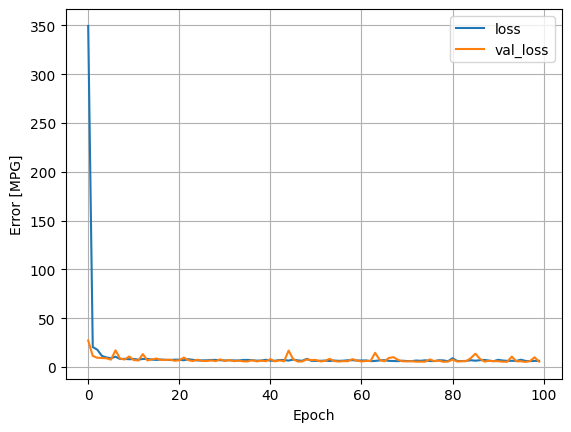

In [ ]:
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
# plt.ylim([o, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)

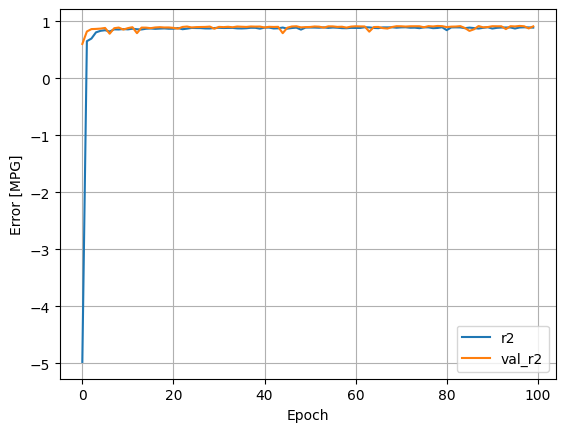

In [ ]:
plt.plot(train_r2, label='r2')
plt.plot(val_r2, label='val_r2')
# plt.ylim([o, 40])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)